# Vive Position Calibration using Several Points and Minimisation
The following script is made to calibrate the position of the base stations using several points and formulating a minimisation-problem to fit the position of the two base-stations to each other before transforming this system to adhere to a spatially defined coordinate system.

Though theoretically a better approach than the 4-point solution, this method has been known to run into local minima that keeps the optimizer from converging satisfactorily. We know this in part is caused by the systematic deviations in angle we observe (see [validation](Vive Validation.ipynb) under section "Base Station Angle" for details). 

In [1]:
%matplotlib notebook

import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as opt

In [2]:
## Rotation matrices
def rotate_x(ang):
    return np.array([[1,0,0],[0,np.cos(ang),-np.sin(ang)],[0,np.sin(ang),np.cos(ang)]])

def rotate_y(ang):
    return np.array([[np.cos(ang),0,np.sin(ang)],[0,1,0],[-np.sin(ang),0,np.cos(ang)]])

def rotate_z(ang):
    return np.array([[np.cos(ang),-np.sin(ang),0],[np.sin(ang),np.cos(ang),0],[0,0,1]])

def rotate_zyx(x,y,z):
    return np.matmul(rotate_x(x),np.matmul(rotate_y(y),rotate_z(z)))

## Rotation helpers
def transform_to_lh_view(pt, pose):
    rotation = rotate_zyx(pose[3],pose[4],pose[5])
    return np.matmul(rotation,pt-pose[0:3])

def measure_samples(samples, pose):
    output = np.zeros_like(samples)
    for i in range(0,samples.shape[1]):
        output[...,i] = transform_to_lh_view(samples[...,i],pose)
        output[...,i] = output[...,i]/np.linalg.norm(output[...,i])
    return output

## Distance between lines
def line_distance(P,u,Q,v):
    w0 = np.array(P)-np.array(Q)
    a = np.dot(u,u)
    b = np.dot(u,v)
    c = np.dot(v,v)
    d = np.dot(u,w0)
    e = np.dot(v,w0)    
    
    return np.linalg.norm(w0 + ((b*e-c*d)*u-(a*e-b*d)*v)/(a*c-b*b))

def line_distance_front(p1,v1,p2,v2):    
    W0 = np.array(p1) - np.array(p2)

    a = np.dot(v1, v1)
    b = np.dot(v1, v2)
    c = np.dot(v2, v2)
    d = np.dot(v1, W0)
    e = np.dot(v2, W0)

    denom = a*c - b*b
    
    s = (b*e - c*d) / denom
    t = (a*e - b*d) / denom
    
    P = p1 + v1*s
    Q = p2 + v2*t
    
    # return distance only for line in front of base station
    if (np.dot(P-p1, v1) < 0):
        P = p1
    if (np.dot(Q-p2, v2) < 0):
        Q = p2
    
    return np.linalg.norm(P-Q)

def rotate_zyx_to_angles(R):    
    x = -math.atan2(R[1,2],R[2,2])
    y = math.asin(R[0,2])
    z = -math.atan2(R[0,1],R[0,0])
    return np.array([x,y,z])

def normVec(v):
    return v/np.linalg.norm(v)

In [3]:
## Plotting helper functions
def transform_to_pose(vec, pose):
    rotated = np.matmul(rotate_zyx(pose[3],pose[4],pose[5]),vec)
    return rotated + pose[0:3]

def transform_vector_to_pose(vec, pose):
    return np.matmul(rotate_zyx(pose[3],pose[4],pose[5]),vec)

def plot_axes(ax, pose, color):
    scale = 0.5
    ps = np.array([[0,0,1],[0,0,0],[0,1,0],[0,0,0],[1,0,0]]).T
    ps = scale*ps
    
    transformed = np.zeros_like(ps)
    for i in range(0,ps.shape[1]):
        transformed[...,i] = transform_to_pose(ps[...,i],pose)
        
    ax.plot(transformed[0,...],transformed[1,...],transformed[2,...],'-o',markersize=5,markevery=10,color=color)
    
def plot_measured_lines(ax, pose, samples, color, length):
    rotation = rotate_zyx(pose[3],pose[4],pose[5])
    measured = measure_samples(samples, pose)
    for i in range(0,measured.shape[1]):
        line = measured[...,i]/np.linalg.norm(measured[...,i])*length
        rotated = np.matmul(rotation,line)+pose[0:3]

        ax.plot([pose[0],rotated[0]],[pose[1],rotated[1]],[pose[2],rotated[2]],'--',color=color)
        
def plot_measured_lines2(ax, pose, measured, color, length):
    rotation = rotate_zyx(pose[3],pose[4],pose[5])
    #measured = measure_samples(samples, pose)
    for i in range(0,measured.shape[1]):
        line = measured[...,i]/np.linalg.norm(measured[...,i])*length
        rotated = np.matmul(rotation,line)+pose[0:3]

        ax.plot([pose[0],rotated[0]],[pose[1],rotated[1]],[pose[2],rotated[2]],'-',color=color, alpha=0.6, lw=0.4)

In [4]:
## hAngle is angle in horizontal plane, vAngle in vertical.
def measured_angles_to_vector(hAngle, vAngle):
    y = np.sin(hAngle)
    x = np.sin(vAngle)
    z = (1-np.sin(hAngle)**2-np.sin(vAngle)**2)**0.5
    return np.array([x,y,z]).T

### Reading data-points or input manually          
#data = np.loadtxt(open("FILENAME", "rb"), delimiter=",", skiprows=1)

data = np.array([[-0.1324063 , -0.20348653,  0.1092956 , -0.1373839 ],
       [-0.06606588, -0.241081  ,  0.03299012, -0.07948918],
       [ 0.00734387, -0.28111848, -0.03585261, -0.02582142],
       [ 0.08710127, -0.32440883, -0.0993386 ,  0.02290227],
       [-0.1917443 , -0.25598393,  0.17656827, -0.0700229 ],
       [-0.25709023, -0.3136574 ,  0.2359915 , -0.00850857],
       [-0.24115813, -0.42059075,  0.19790666,  0.08808769],
       [-0.13624286, -0.31807803,  0.11247162,  0.0033521 ],
       [-0.03372648, -0.35028003,  0.01777376,  0.04133479],
       [ 0.04336819, -0.44409848, -0.02935516,  0.12057842],
       [-0.1347303 , -0.49336973,  0.1077308 ,  0.14414993],
       [-0.24685544, -0.19140019,  0.26410059, -0.1655845 ],
       [-0.1484878 , -0.133989  ,  0.1371715 , -0.25629743],
       [-0.0516663 , -0.16025093, -0.00291017, -0.19854753],
       [-0.12865594, -0.08504003,  0.10553519, -0.35872361],
       [-0.2139658 , -0.06953147,  0.2577041 , -0.5022223 ],
       [ 0.178072  , -0.24148273, -0.18318553,  0.14830857],
       [-0.02108021,  0.02674724, -0.09501194, -0.13155845],
       [ 0.0229672 ,  0.01056387, -0.14915167, -0.08649187],
       [ 0.07452043, -0.00889037, -0.20379097, -0.0382662 ],
       [ 0.11964547, -0.02824217, -0.24264547,  0.0034279 ],
       [-0.24950913, -0.27755487,  0.20589887,  0.1490889 ],
       [-0.51117283, -0.3576123 ,  0.4150047 ,  0.192826  ],
       [-0.32757758, -0.14601715,  0.34110336, -0.00121924],
       [-0.13620307,  0.0257063 ,  0.1072575 , -0.3498338 ],
       [-0.25448853, -0.06841807,  0.28306863, -0.12624657],
       [ 0.02915703, -0.21974855, -0.05952135,  0.11216968],
       [-0.13984384, -0.15606174,  0.0910619 ,  0.32435094],
       [-0.1298462 ,  0.03105397,  0.07921527,  0.11882097],
       [-0.00194477, -0.03513213, -0.05924167,  0.22513607],
       [ 0.14433763, -0.09971667, -0.164468  ,  0.2986605 ],
       [-0.2611565 , -0.0442019 ,  0.22897707,  0.21709793],
       [-0.41650053, -0.156089  ,  0.33573983,  0.31695747],
       [-0.13630217, -0.11456693,  0.08837517,  0.29882127]])

meas1 = measured_angles_to_vector(data[:,0], data[:,1]).T #transformToCoordinateSystem( measured_angles_to_vector(data[:,0], data[:,1]), Qb )
meas2 = measured_angles_to_vector(data[:,2], data[:,3]).T

In [5]:
print measured_angles_to_vector(0,-np.pi/2)

[-1.  0.  0.]


In [6]:
print sum(meas1[0]/len(meas1[2]))
print sum(meas2[0]/len(meas2[2]))

-0.177828383914
0.00895868445869


### 1. Determining Position of C Relative to B
Dataset of angles measured from base stations is givens. We assume B is located at (0,0,0) and with rotation (0,0,0) and construct and solve an optimization problem to determine position of C. 

Constraints: 
- distance between base stations is 1 unit. 
- base stations need to point in opposite directions. 
- C need to be in front of B. 

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1.72553639115
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 4


<IPython.core.display.Javascript object>


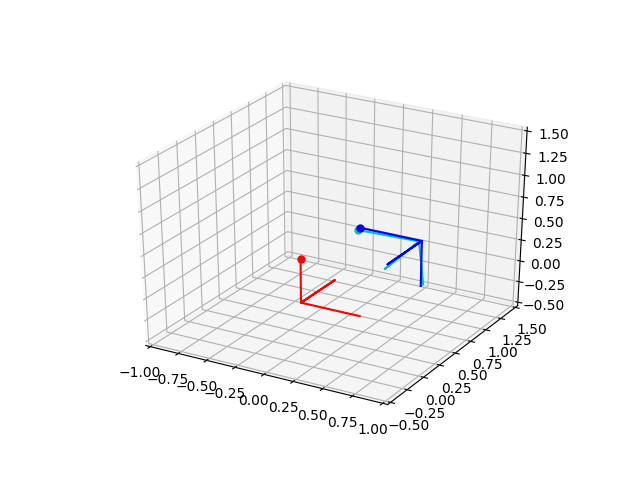

<IPython.core.display.Javascript object>


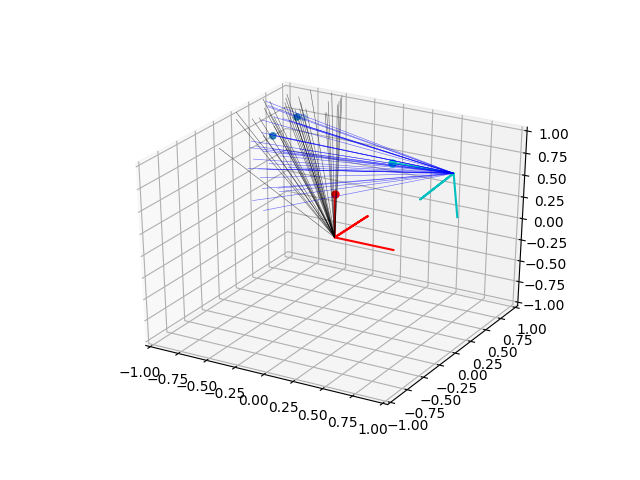

In [7]:
## Solve optimization problem
# Initial guess
q1 = [0.0, 0, 0, 0, 0, 0]
q2 = [1, 0, 1, 0, 3*np.pi/2, np.pi] # Pretty good guess to start with
#q2 = [1, 0, 1, 0, 3*np.pi/2, np.pi] # Pretty good guess to start with
dists = []

# Objective function
def objective(pose):
    sum = 0
    P = q1[0:3]
    Q = pose[0:3]
    rotation = rotate_zyx(pose[3],pose[4],pose[5])
    distss = []
    for i in range(meas1.shape[1]):
        u = meas1[...,i]
        v = np.matmul(rotation, meas2[...,i])
        dist = line_distance_front(P,u,Q,v)
        distss.append(dist)
        sum += dist
    dists.append(distss)
    return sum

# Constraints
def distance(pose):
    return np.linalg.norm(pose[0:3])-1
cstr_distance = { 'type': 'eq', 'fun': distance }

def point_opposite(pose):
    rotation = rotate_zyx(pose[3],pose[4],pose[5])
    z1 = np.array([0,0,1])
    z2 = np.matmul(rotation, np.array([0,0,1]))
    return -np.dot(z1,z2)
cstr_point_opposite = { 'type': 'ineq', 'fun': point_opposite}

def point_towards(pose):
    rotation = rotate_zyx(pose[3],pose[4],pose[5])
    z1 = np.array(pose[0:3])
    z2 = np.matmul(rotation, np.array([0,0,1]))
    return -np.dot(z1,z2)
cstr_point_towards = { 'type': 'ineq', 'fun': point_towards}

# Bounds (translation positive in z - in front of other lighhouse, and rotations in [0,2*pi])
bounds = [
    (-1, 1),
    (-1, 1),
    (0, 1),
    (-np.pi, np.pi),
    (-np.pi, np.pi),
    (-np.pi, np.pi)
]

## Do optimization
res = opt.minimize(objective,q2,
             method='SLSQP',
             jac=False,
             bounds=bounds,
             constraints=[cstr_distance,cstr_point_opposite,cstr_point_towards],
             options={'disp': True, 'ftol': 1e-9, 'maxiter': 1000}
)

## Plot resulting estimate
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')

# Shift estimate to position of 2nd LH
P1 = q1
P2 = res['x']

# Poses of LH
plot_axes(ax2,P1,'r')
plot_axes(ax2,P2,'c')
plot_axes(ax2,q2,'b')

ax2.set_xlim([-1,1])
ax2.set_ylim([-.5,1.5])
ax2.set_zlim([-.5,1.5])

## plot with lines
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')

Po1 = P1#[0, 0, 2.5, -np.pi/6, np.pi/6, np.pi/4]
Po2 = P2#[2.8, 2.8, 2.5, np.pi/6, -np.pi/6, 5*np.pi/4]

#Po1 = [0, 0, 0, 0, 0, 0]
#Po2 = [1, 0, 0, 0, 0, 0]

plot_axes(ax2,Po1,'r')
plot_axes(ax2,Po2,'c')

ax2.set_xlim3d(-1,1)
ax2.set_ylim3d(-1,1)
ax2.set_zlim3d(-1,1)

plot_measured_lines2(ax2, Po1, meas1, "k", 1.5)
plot_measured_lines2(ax2, Po2, meas2, "b", 1.5)

<IPython.core.display.Javascript object>


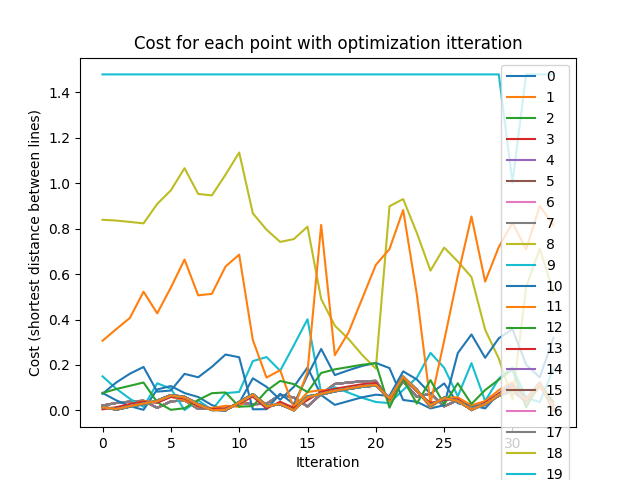

In [8]:
plt.figure()
[plt.plot(range(len(d)), d) for d in dists]
plt.legend(range(len(d)))
plt.xlabel('Itteration')
plt.ylabel('Cost (shortest distance between lines)')
plt.title('Cost for each point with optimization itteration')

In [9]:
def position(p1,v1,p2,v2):
    # Point of intersection
    
    W0 = p1 - p2

    a = np.dot(v1, v1)
    b = np.dot(v1, v2)
    c = np.dot(v2, v2)
    d = np.dot(v1, W0)
    e = np.dot(v2, W0)

    denom = a*c - b*b
    
    s = (b*e - c*d) / denom
    t = (a*e - b*d) / denom
    
    P = p1 + v1*s
    Q = p2 + v2*t

    point = (P+Q)/2
    return point

def positionFromMeasurement(ang, P1, P2):
    va = measured_angles_to_vector(ang[0], ang[1])
    vb = measured_angles_to_vector(ang[2], ang[3])
    
    v1 = transform_vector_to_pose(va,P1)
    v2 = transform_vector_to_pose(vb,P2)
    
    return position(P1[0:3],v1,P2[0:3],v2)


data = [[-0.1327934, -0.20342617, -0.044094, -0.29171177],
 [-0.0661195, -0.24125297, -0.1219269, -0.23382247],
 [0.00722473, -0.28129783, -0.19208193, -0.18038883],
 [-0.1922547, -0.25594557, 0.023179, -0.224814],
 [-0.25785843, -0.3135612, 0.0824434, -0.1634431]]

aa = np.array(data[2])
ab = np.array(data[0])
ac = np.array(data[4])

pa = positionFromMeasurement(aa, P1, P2)
pb = positionFromMeasurement(ab, P1, P2)
pc = positionFromMeasurement(ac, P1, P2)

s = np.vstack((pa,pb,pc)).T

ax2.scatter(s[0], s[1], s[2])

### 2. Translation to Local Cartesian Coordinate Location
Knowing the relative position of C with respect to B, we are not ready to embed the local coordinate system we have obtained in the Cartesian coordiantes we which to define for the room. 

This is obtained through three transformations:
- translation
 - we define a point to be the origin of the system
- rotation
 - we define xy-plane as floor or table surface and define a x-axies direction 
- scaling
 - we define two points in space with known spearation

We use set distance between pairs of points to determine the scale of the setup (distance between base stations). We collect multiple pairs of 1m separated data-points and average. There should be a mechanism here to alert if there is significant variance/discard outliers.

<IPython.core.display.Javascript object>


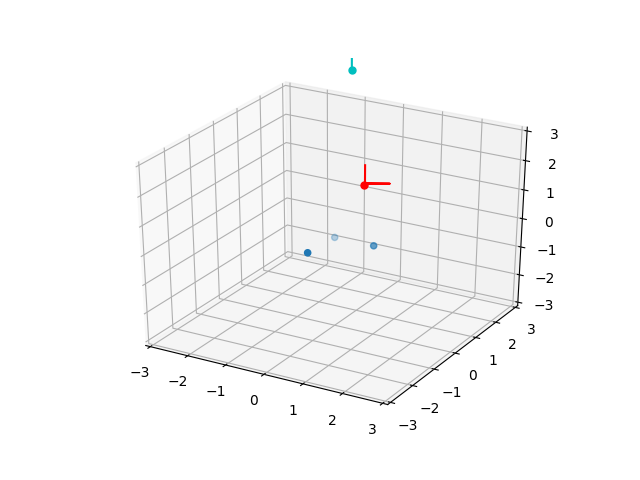

[ 2.56595986 -3.21434945  4.04446248 -2.23638251 -0.47166083 -1.87943542] [-0.59175053  1.78082963  5.21850585  2.58721815  0.2924596   0.99706149]


In [10]:
PB = np.array(P1, copy=True)
PC = np.array(P2, copy=True)

v1 = pa-pb
v2 = pc-pb
n  = normVec((np.cross(v1, v2)))

# Translation
t = pb

PB[0:3] = PB[0:3]-t
PC[0:3] = PC[0:3]-t

# Rotate location
iVec = normVec(v1)
kVec = normVec(-np.cross(v1,v2))
jVec = normVec(np.cross(kVec,iVec))

M = np.vstack((iVec, jVec, kVec)).T
R = np.linalg.inv(M)

PB[0:3] = np.matmul(R,PB[0:3])
PC[0:3] = np.matmul(R,PC[0:3])


def rotate_and_pose(R,vec,P):
    return normVec(np.matmul(R, transform_vector_to_pose(vec, P)))


# Rotate orientation
iVecB = rotate_and_pose(R,[1,0,0],PB)
jVecB = rotate_and_pose(R,[0,1,0],PB)
kVecB = rotate_and_pose(R,[0,0,1],PB)

iVecC = rotate_and_pose(R,[1,0,0],PC)
jVecC = rotate_and_pose(R,[0,1,0],PC)
kVecC = rotate_and_pose(R,[0,0,1],PC)

rotB = np.array([iVecB, jVecB, kVecB]).T
rotC = np.array([iVecC, jVecC, kVecC]).T

PB[3:6] = rotate_zyx_to_angles(rotB)
PC[3:6] = rotate_zyx_to_angles(rotC)

# Scaling
s = 1/np.linalg.norm(v1)

PB[0:3] = np.multiply(PB[0:3], s)
PC[0:3] = np.multiply(PC[0:3], s)


## Plot resulting estimate
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')

# Poses of LH
plot_axes(ax2,PB,'r')
plot_axes(ax2,PC,'c')

paNew = positionFromMeasurement(aa, PB, PC)
pbNew = positionFromMeasurement(ab, PB, PC)
pcNew = positionFromMeasurement(ac, PB, PC)

sNew = np.vstack((paNew,pbNew,pcNew)).T

ax2.scatter(sNew[0], sNew[1], sNew[2])
ax2.set_xlim3d(-3,3)
ax2.set_ylim3d(-3,3)
ax2.set_zlim3d(-3,3)

print PB, PC

In [11]:
# Test: 
# p,-2.943105,4.667657,3.507365,,
pb

ang1 = [-0.132575,-0.203491,0.109485,-0.137350]

print positionFromMeasurement(ac, PB, PC)
print ab

[ -6.13119697e-02  -1.08859258e+00   1.11022302e-15]
[-0.1327934  -0.20342617 -0.044094   -0.29171177]


In [12]:
#rotate_zyx_to_angles()
print pa, pb, pc
print P1, P2

[-0.32867392  0.11266406  1.20976395] [-0.265582   -0.08522318  1.31570361] [-0.38348953 -0.23138988  1.14435701]
[0.0, 0, 0, 0, 0, 0] [ 0.98648107 -0.01760844  1.          0.04484837  4.6760137   3.09510888]
